In [7]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Review: Comparing Two Samples

In [2]:
def difference_of_means(table, numeric_label, group_label):
    """
    Takes: name of table, column label of numerical variable,
    column label of group-label variable
    
    Returns: Difference of means of the two groups
    """
    
    #table with the two relevant columns
    reduced = table.select(numeric_label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [4]:
def one_simulated_difference(table, numeric_label, group_label):
    """
    Takes: name of table, column label of numerical variable,
    column label of group-label variable
    
    Returns: Difference of means of the two groups after shuffling labels
    """
    
    # array of shuffled labels
    # table.sample(with_replacement = False) returns a table of the same size and we are sampling WITHOUT replacement, which means
    # no duplicate entries
    # and essentially shuffling the entire table
    # meaning, rows are in a different order
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    # to simulate under the null, could strip the original association of babies and moms (specifically babies weight and mom's smoking habits)  
    # and then look at the categorical label column of "Maternal Smoker", shuffle it and then
    # randomly assign the categorical labels of "smoking" and "nonsmoking"
    # or Maternal Smoker = False or = True
    # and "re-associate" these categorical labels to the babies in the table

    # NULL: The average babies' weight between smoking and non-smoking groups is about the same.
    # ALTERNATIVE: Nonsmoking group's average babies' weight was higher than the smoking group's average babies' weight.
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(numeric_label).with_column('Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, numeric_label, 'Shuffled Label')   

In [9]:
births = Table.read_table('data/baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [6]:
births.group('Maternal Smoker', np.average)

Maternal Smoker,Birth Weight average,Gestational Days average,Maternal Age average,Maternal Height average,Maternal Pregnancy Weight average
False,123.085,279.874,27.5441,64.014,129.48
True,113.819,277.898,26.7364,64.1046,126.919


In [10]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')
# smoking group - nonsmoking (in terms of average baby's birth weight)
# on average, babies from the smoking group weighed ~9.26 oz less than the babies from the nonsmoking group

-9.266142572024918

In [19]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
# a/b testing, which allows me to simulate under the null

0.6750369456251804

# Randomized Control Experiment

In [21]:
botox = Table.read_table('data/bta.csv')
botox.group('Group')

Group,count
Control,16
Treatment,15


# Task:
- Summarize the dataset: show the unique combinations
    - How many people got treatment and experienced improvements?
    - How many people got placebo and experienced improvements?
    - How many people got treatment and didnt experienced improvements?
    - How many people got placebo and didnt experienced improvements?
- Calculate the share of improvements per group

In [25]:
#botox.show()
# Result Pain improvement = 1
# Result No Pain improvement = 0

botox.pivot('Result', 'Group')

Group,0.0,1.0
Control,14,2
Treatment,6,9


In [26]:
botox.group('Group', np.average)
# In the control group, on average patients reported a 0.125 pain improvement on a 0-1 scale (most reported no pain improvement)
# in the treatment group, on anverage patients reported a 0.5 pain improvement on a 0-1 scale (most reported there was pain improvement)

# botox and pain improvement
# because there is random assignment in the way we conducted this study, we can determine a causal relationship between 
# botox and pain improvement
# all other differences between the two group (control and treatment) is due to chance and the treatment (botox) itself.

Group,Result average
Control,0.125
Treatment,0.6


## Tickets
is the distribution of the 

- 31 “treatment” values in Column 1 (including the unknown ones) 
different from the distribution of the 
- 31 “control” values in Column 2 (again including the unknown ones)?

In [27]:
botox = botox.with_column('Outcome if assigned treatment', botox.column('Result'))
botox.column('Outcome if assigned treatment')[botox.column('Group') != 'Treatment'] = np.nan

botox = botox.with_column('Outcome if assigned control', botox.column('Result'))
botox.column('Outcome if assigned control')[botox.column('Group') != 'Control'] = np.nan

botox.show()

Group,Result,Outcome if assigned treatment,Outcome if assigned control
Control,1,nan,1
Control,1,nan,1
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0


# Testing the Hypothesis

In [28]:
observed_diff = difference_of_means(botox, 'Result', 'Group')
observed_diff
# Treatment group - control group ( in terms of average pain improvement rating)
# remember, result = 0, means no pain improvement
# result = 1, means there was pain improvement

# positive value in the difference means, botox does make a difference in pain improvement
# a value close to 0 means botox does not make a difference in pain improvement
# a negative value would mean botox worsens pain

0.475

In [39]:
one_simulated_difference(botox, 'Result', 'Group')
# simulate under the null
# null: there is no difference between the treatment and the control group, in terms of pain improvement
# in other words, botox does not make a diffrence in pain improvement
# so the difference between the simulated groups, when we use a/b testing, should be close to 0

-0.041666666666666685

In [40]:
one_simulated_difference(botox, 'Result', 'Group')


-0.041666666666666685

In [41]:
one_simulated_difference(botox, 'Result', 'Group')


0.08750000000000002

In [42]:
one_simulated_difference(botox, 'Result', 'Group')


-0.041666666666666685

In [43]:
one_simulated_difference(botox, 'Result', 'Group')


-0.041666666666666685

# Task: 
1. Simulate the difference 10k times
1. Create a table containing the simulations
1. Plot the histogram
    - Question: in which direction is the alternative?
    - Where on the histogram is the *observed* difference?
    - Bonus: Add the observed difference as a dot into the histogram (use `plots.scatter()`).
1. Calculate the p-value ([hint](https://inferentialthinking.com/chapters/12/1/AB_Testing.html#conclusion-of-the-test))
1. Choose a p-value cutoff

In [45]:
simulated_diffs = make_array() # initialize an array outside the for loop
# to then capture all our simulated_diffs
for i in np.arange(10_000):
    sim_diff = one_simulated_difference(botox, 'Result', 'Group')
    simulated_diffs = np.append(simulated_diffs, sim_diff) 
    # each time our for loop runs, we append sim_diff to our simulated_diffs array
    # by the end of this for loop, we will have 10,000 simulated difference inside simulated_diffs

In [46]:
len(simulated_diffs)

10000

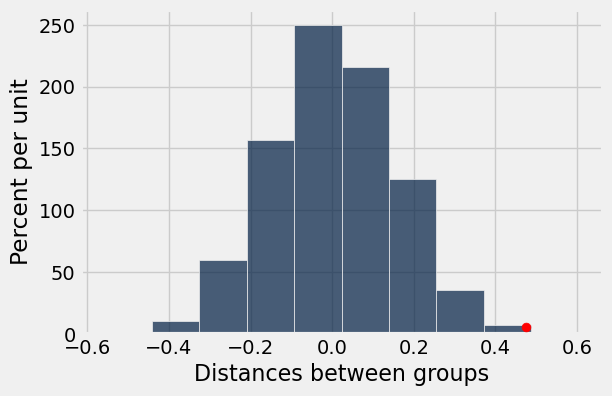

In [49]:
col_name = 'Distances between groups'
Table().with_column(col_name, simulated_diffs).hist(col_name)
# empirical distribution, essentially a collection of all our simulated differences portrayed in the following histogram
# lots and lots of times we had absolutely no difference in pain improvement between the two groups
# it's centered at 0
plots.scatter(observed_diff, 0.05, color = 'red', s = 40, zorder = 3)
# red dot = observed difference between two groups, in terms of pain improvement

In [ ]:
# from this visualization above, how would you conclude your hypothesis testing? 
# would you fail to reject the null?
# or reject the null, and lean toward alternative



In [ ]:
# what is the p-value?
# how would you calculate it? if you need a quantifiable measure to conclude your hypothesis test
# assume p value cut-off is 5%

